# 03. Modeling


### Purpose: Stroke Prediction

According to the NIH National Heart, Lung, and Blood Institute (HHLI):

>Strokes are caused by blocked blood flow to the brain (ischemic stroke) or sudden bleeding in the brain (hemorrhagic stroke). Many things raise your risk of stroke, and many of these can be changed to help prevent a stroke or prevent another stroke.

The aim of this analysis is to compare different models' accuracy when predicting a stroke based on key health factors.  

### Comparing the following models:
1. Linear Support Vector Classifier (SVC)
3. Logistic Regression
4. Multi-layer Perceptron (MLP)
5. Adaboost (had the best accuracy and F1 score out of the decsion trees tested)

---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score
from sklearn.metrics import roc_curve, RocCurveDisplay
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay

## 1. Prepare data

### 1.1. Read scaled data and selected features

In [2]:
# read scaled data
scaled_df = pd.read_csv('../data/processed/2020_BRFSS_stroke_risk_factors_scaled.csv', index_col=0)
scaled_df

,age,sex,race,bmi_gt_25,coronary_heart_disease,diabetes,smoker,arthritis,heavy_alcohol,physical_activity,poor_mental_health,stroke
0,0.583333,1.0,0.0,0.0,0.0,0.333333,0.333333,1.0,0.0,1.0,1.000000,0.0
1,1.000000,1.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,1.0,0.000000,1.0
2,0.750000,0.0,0.0,1.0,0.0,0.333333,1.000000,1.0,0.0,1.0,1.000000,0.0
3,0.916667,1.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0
4,0.333333,1.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,1.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
323684,0.250000,0.0,1.0,1.0,0.0,0.000000,1.000000,0.0,0.0,1.0,0.000000,0.0
323685,0.416667,1.0,1.0,0.0,0.0,0.000000,0.000000,0.0,0.0,1.0,0.000000,0.0
323686,0.083333,1.0,1.0,1.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0
323687,1.000000,1.0,1.0,1.0,0.0,0.000000,0.000000,0.0,0.0,1.0,0.000000,0.0


In [5]:
# selected features
selected_features = ['age', 'race', 'coronary_heart_disease', 'smoker', 
                     'arthritis', 'poor_mental_health', 'diabetes']

### 1.2. Split into train and test set

In [3]:
from sklearn.model_selection import train_test_split
from collections import Counter

x_df = scaled_df.drop(columns=['stroke'])
y_df = scaled_df['stroke']

X_train, X_test, y_train, y_test = train_test_split(x_df, y_df, test_size=0.3, random_state=100)

print(f"Training target statistics: {Counter(y_train)}")
print(f"Testing target statistics: {Counter(y_test)}")

Training target statistics: Counter({0.0: 217791, 1.0: 8791})
Testing target statistics: Counter({0.0: 93337, 1.0: 3770})


**Random under-sampling**

In [4]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=42)
X_rus, y_rus = rus.fit_resample(X_train, y_train)

print('Training target statistics:', Counter(y_rus))
print('Testing target statistics:', Counter(y_test))

Training target statistics: Counter({0.0: 8791, 1.0: 8791})
Testing target statistics: Counter({0.0: 93337, 1.0: 3770})


**Keep selected features**

In [8]:
sel_X_train, sel_X_test = X_rus[selected_features], X_test[selected_features]

print('                      X         y')
print('-'*37)
print('Train data     |', X_rus.shape, y_rus.shape)
print('Test data      |', X_test.shape, y_test.shape)
print('Selected Train |', sel_X_train.shape,'', y_rus.shape)
print('Selected Test  |', sel_X_test.shape,'', y_test.shape)

                      X         y
-------------------------------------
Train data     | (17582, 11) (17582,)
Test data      | (97107, 11) (97107,)
Selected Train | (17582, 7)  (17582,)
Selected Test  | (97107, 7)  (97107,)


### 1.3. 5-fold cross validation

In [13]:
from sklearn.model_selection import StratifiedKFold

five_fold = StratifiedKFold(n_splits=5)

**Function to run stratified K-fold cross validation on each model**

In [20]:
import time

def skfold_cross_val(X, y, model, fold, params):
  start = time.time()
  result = []
  i, tot = 1, len(params)
  
  for param in params:
      iter_start = time.time()
      print('', '-'*80)
      print(f'- Trying [{i}/{tot}]... {param}')
      accuracy = []
      f1 = []
      for train_idx, val_idx in fold.split(X, y):
          X_train_cv, X_val_cv = X.iloc[train_idx, :], X.iloc[val_idx, :]
          y_train_cv, y_val_cv = y.iloc[train_idx], y.iloc[val_idx]
          temp = copy.deepcopy(model).set_params(**param)
          temp.fit(X_train_cv, y_train_cv)
          accuracy.append(temp.score(X_val_cv, y_val_cv))
          f1.append(f1_score(y_val_cv, temp.predict(X_val_cv)))
      
      print('  Accuracy:', np.mean(accuracy),'\n  F1 score:', np.mean(f1), end=' ')
      tot_time = time.time() - start
      param_time = time.time() - iter_start
      print(f' ... {int(param_time/60)}min {int(param_time%60)}sec for this parameter \
        (total {int(tot_time/60)}min {int(tot_time%60)}sec)')
      print()
      result.append((np.mean(accuracy), np.mean(f1)))
      i+=1
    
  return result

## 2. SVC

Replaced Naive Bayes classifier

**Naive model performance**

In [17]:
from sklearn.svm import SVC

svc = SVC(kernel='linear')
svc.fit(X_rus, y_rus)
svc.score(X_test, y_test)

0.6625577970692124

**Comparing different parameters**

In [21]:
penalty = [0.1, 1, 10]
kernel = ['linear', 'rbf']
svc_params = [{'C': c, 'kernel': k} for c in penalty for k in kernel]
svc_params = svc_params + [{'C': c, 'kernel': 'poly', 'degree': d} for c in penalty for d in [2,3,4]]

### 2.1. All features

In [22]:
svc = SVC(random_state=42)
svc_all = skfold_cross_val(X_rus, y_rus, svc, five_fold, svc_params)

 --------------------------------------------------------------------------------
- Trying [1/15]... {'C': 0.1, 'kernel': 'linear'}
  Accuracy: 0.7081676259274391 
  F1 score: 0.722064255607058  ... 0min 26sec for this parameter         (total 0min 26sec)

 --------------------------------------------------------------------------------
- Trying [2/15]... {'C': 0.1, 'kernel': 'rbf'}
  Accuracy: 0.7074854202390275 
  F1 score: 0.7288115727341415  ... 0min 59sec for this parameter         (total 1min 26sec)

 --------------------------------------------------------------------------------
- Trying [3/15]... {'C': 1, 'kernel': 'linear'}
  Accuracy: 0.7079401916839483 
  F1 score: 0.7221939208732997  ... 0min 29sec for this parameter         (total 1min 55sec)

 --------------------------------------------------------------------------------
- Trying [4/15]... {'C': 1, 'kernel': 'rbf'}
  Accuracy: 0.7122057886883245 
  F1 score: 0.7295860298299007  ... 0min 55sec for this parameter        

### 2.2. Selected features

In [39]:
svc = SVC(random_state=42)
svc_sel = skfold_cross_val(sel_X_train, y_rus, svc, five_fold, svc_params)

 --------------------------------------------------------------------------------
- Trying [1/15]... {'C': 0.1, 'kernel': 'linear'}
  Accuracy: 0.7013994435608225 
  F1 score: 0.7206258214134456  ... 0min 40sec for this parameter         (total 0min 40sec)

 --------------------------------------------------------------------------------
- Trying [2/15]... {'C': 0.1, 'kernel': 'rbf'}
  Accuracy: 0.7043570591468127 
  F1 score: 0.7296484282635678  ... 1min 28sec for this parameter         (total 2min 9sec)

 --------------------------------------------------------------------------------
- Trying [3/15]... {'C': 1, 'kernel': 'linear'}
  Accuracy: 0.7024232049563909 
  F1 score: 0.7206279507948483  ... 0min 43sec for this parameter         (total 2min 52sec)

 --------------------------------------------------------------------------------
- Trying [4/15]... {'C': 1, 'kernel': 'rbf'}
  Accuracy: 0.7091913226283002 
  F1 score: 0.7304786327662651  ... 1min 29sec for this parameter        

## 3. Logistic Regression

In [24]:
penalty = ['l1', 'l2']
reg = [1.0, 0.5, 0.1]
lr_params = [{'C': c} for c in reg]
lr_params = lr_params + [{'solver': 'liblinear', 'penalty': pen, 'C': c} for pen in penalty for c in reg]

### 3.1 All features

In [26]:
lr = LogisticRegression(max_iter=2000, random_state=42)
lr_all = skfold_cross_val(X_rus, y_rus, lr, five_fold, lr_params)

 --------------------------------------------------------------------------------
- Trying [1/9]... {'C': 1.0}
  Accuracy: 0.7073142703908821 
  F1 score: 0.7123303346709436  ... 0min 0sec for this parameter         (total 0min 0sec)

 --------------------------------------------------------------------------------
- Trying [2/9]... {'C': 0.5}
  Accuracy: 0.7071436866214257 
  F1 score: 0.7121480512091675  ... 0min 0sec for this parameter         (total 0min 0sec)

 --------------------------------------------------------------------------------
- Trying [3/9]... {'C': 0.1}
  Accuracy: 0.707029904804973 
  F1 score: 0.7117444822191487  ... 0min 0sec for this parameter         (total 0min 0sec)

 --------------------------------------------------------------------------------
- Trying [4/9]... {'solver': 'liblinear', 'penalty': 'l1', 'C': 1.0}
  Accuracy: 0.7076555187981795 
  F1 score: 0.7127949440980739  ... 0min 0sec for this parameter         (total 0min 0sec)

 --------------------

### 3.2. Select features

In [27]:
lr = LogisticRegression(max_iter=2000, random_state=42)
lr_sel = skfold_cross_val(sel_X_train, y_rus, lr, five_fold, lr_params)

 --------------------------------------------------------------------------------
- Trying [1/9]... {'C': 1.0}
  Accuracy: 0.700091316579345 
  F1 score: 0.7059758159308285  ... 0min 0sec for this parameter         (total 0min 0sec)

 --------------------------------------------------------------------------------
- Trying [2/9]... {'C': 0.5}
  Accuracy: 0.7002619488698321 
  F1 score: 0.706036520801357  ... 0min 0sec for this parameter         (total 0min 0sec)

 --------------------------------------------------------------------------------
- Trying [3/9]... {'C': 0.1}
  Accuracy: 0.6987834645503733 
  F1 score: 0.7045505890012003  ... 0min 0sec for this parameter         (total 0min 0sec)

 --------------------------------------------------------------------------------
- Trying [4/9]... {'solver': 'liblinear', 'penalty': 'l1', 'C': 1.0}
  Accuracy: 0.700148199400733 
  F1 score: 0.7060514193819591  ... 0min 0sec for this parameter         (total 0min 0sec)

 ----------------------

## 4. MLP

Using logistic and relu activation

In [28]:
hidden_layer_sizes = [(32), (64), (128), (256), 
                      (32, 32), (64, 64), (128, 128), (256, 256), 
                      (32, 32, 32), (64, 64, 64), (128, 128, 128), 
                      (32, 32, 32, 32), (64, 64, 64, 64), (128, 128, 128, 128)]
activation = ['logistic', 'relu']
mlp_params =[{'hidden_layer_sizes': hidden, 'activation': act}
             for hidden in hidden_layer_sizes for act in activation]

### 4.1. All features

In [29]:
mlp = MLPClassifier(max_iter=3000, random_state=42)
mlp_all = skfold_cross_val(X_rus, y_rus, mlp, five_fold, mlp_params)

 --------------------------------------------------------------------------------
- Trying [1/28]... {'hidden_layer_sizes': 32, 'activation': 'logistic'}
  Accuracy: 0.708110759279728 
  F1 score: 0.7211015219633813  ... 0min 9sec for this parameter         (total 0min 9sec)

 --------------------------------------------------------------------------------
- Trying [2/28]... {'hidden_layer_sizes': 32, 'activation': 'relu'}
  Accuracy: 0.7183483085407042 
  F1 score: 0.7322145114706009  ... 0min 22sec for this parameter         (total 0min 31sec)

 --------------------------------------------------------------------------------
- Trying [3/28]... {'hidden_layer_sizes': 64, 'activation': 'logistic'}
  Accuracy: 0.7070298886312962 
  F1 score: 0.7153324006798096  ... 0min 12sec for this parameter         (total 0min 44sec)

 --------------------------------------------------------------------------------
- Trying [4/28]... {'hidden_layer_sizes': 64, 'activation': 'relu'}
  Accuracy: 0.717

### 4.2. Select features

In [30]:
mlp = MLPClassifier(max_iter=3000, random_state=42)
mlp_sel = skfold_cross_val(sel_X_train, y_rus, mlp, five_fold, mlp_params)

 --------------------------------------------------------------------------------
- Trying [1/28]... {'hidden_layer_sizes': 32, 'activation': 'logistic'}
  Accuracy: 0.7028214170534601 
  F1 score: 0.7142436051702306  ... 0min 10sec for this parameter         (total 0min 10sec)

 --------------------------------------------------------------------------------
- Trying [2/28]... {'hidden_layer_sizes': 32, 'activation': 'relu'}
  Accuracy: 0.7159028486050042 
  F1 score: 0.730387134576422  ... 0min 18sec for this parameter         (total 0min 29sec)

 --------------------------------------------------------------------------------
- Trying [3/28]... {'hidden_layer_sizes': 64, 'activation': 'logistic'}
  Accuracy: 0.7018546193476639 
  F1 score: 0.7193383390005644  ... 0min 21sec for this parameter         (total 0min 50sec)

 --------------------------------------------------------------------------------
- Trying [4/28]... {'hidden_layer_sizes': 64, 'activation': 'relu'}
  Accuracy: 0.7

## 5. AdaBoost

In [31]:
n_estimators = [50, 100, 200, 500]
learning_rate = [0.1, 1, 10]
ab_params = [{'n_estimators': est, 'learning_rate': lr}
            for est in n_estimators for lr in learning_rate]

### 5.1. All features

In [32]:
ab = AdaBoostClassifier(random_state=42)
ab_all = skfold_cross_val(X_rus, y_rus, ab, five_fold, ab_params)

 --------------------------------------------------------------------------------
- Trying [1/12]... {'n_estimators': 50, 'learning_rate': 0.1}
  Accuracy: 0.7050965358248559 
  F1 score: 0.716859921755953  ... 0min 2sec for this parameter         (total 0min 2sec)

 --------------------------------------------------------------------------------
- Trying [2/12]... {'n_estimators': 50, 'learning_rate': 1}
  Accuracy: 0.7161301372854035 
  F1 score: 0.7201394763880843  ... 0min 2sec for this parameter         (total 0min 4sec)

 --------------------------------------------------------------------------------
- Trying [3/12]... {'n_estimators': 50, 'learning_rate': 10}
  Accuracy: 0.6577179815380714 
  F1 score: 0.7130113093956773  ... 0min 2sec for this parameter         (total 0min 6sec)

 --------------------------------------------------------------------------------
- Trying [4/12]... {'n_estimators': 100, 'learning_rate': 0.1}
  Accuracy: 0.7113525948885359 
  F1 score: 0.717803124

### 5.2. Select features

In [34]:
ab = AdaBoostClassifier(random_state=42)
ab_sel = skfold_cross_val(sel_X_train, y_rus, ab, five_fold, ab_params)

 --------------------------------------------------------------------------------
- Trying [1/12]... {'n_estimators': 50, 'learning_rate': 0.1}
  Accuracy: 0.7041866856351549 
  F1 score: 0.7216127276616755  ... 0min 2sec for this parameter         (total 0min 2sec)

 --------------------------------------------------------------------------------
- Trying [2/12]... {'n_estimators': 50, 'learning_rate': 1}
  Accuracy: 0.7139691884987044 
  F1 score: 0.7192070239646214  ... 0min 2sec for this parameter         (total 0min 4sec)

 --------------------------------------------------------------------------------
- Trying [3/12]... {'n_estimators': 50, 'learning_rate': 10}
  Accuracy: 0.6577179815380714 
  F1 score: 0.7130113093956773  ... 0min 2sec for this parameter         (total 0min 6sec)

 --------------------------------------------------------------------------------
- Trying [4/12]... {'n_estimators': 100, 'learning_rate': 0.1}
  Accuracy: 0.7083386625598467 
  F1 score: 0.71474118

## 6. Optimal parameters

Analyze results of cross validation
- Accuracy and F1 score averages

### 6.1. Generate cross-validation results

In [35]:
def result_analysis(params, result):
  n = len(params)
  best_accuracy = [0, []]
  best_f1 = [0, []]
  best_avg = [0, []]
  
  for i in range(n):
      accuracy = result[i][0]
      f1 = result[i][1]
      avg = (accuracy + f1)/2
      
      if accuracy > best_accuracy[0]:
          best_accuracy[0], best_accuracy[1] = accuracy, [params[i]]
      elif accuracy == best_accuracy[0]:
          best_accuracy[1].append(params[i])
      
      if f1 > best_f1[0]:
          best_f1[0], best_f1[1] = f1, [params[i]]
      elif f1 == best_f1[0]:
          best_f1[1].append(params[i])
      
      if avg > best_avg[0]:
          best_avg[0], best_avg[1] = avg, [params[i]]
      elif avg == best_avg[0]:
          best_avg[1].append(params[i])
      
  return {'best_accuracy': best_accuracy, 'best_f1': best_f1, 'best_avg': best_avg}

In [42]:
def print_results(result, title):
    accuracy = result['best_accuracy']
    f1 = result['best_f1']
    avg = result['best_avg']
    print(title, '='*(50 - len(title)))
    print(f'  best accuracy: {accuracy[0]}')
    for params in accuracy[1]:
        print('    ', params)        
    print(f'- best f1-score: {f1[0]}')
    for params in f1[1]:
        print('    ', params)        
    print(f'- best average : {avg[0]}')
    for params in avg[1]:
        print('    ', params)
    print('='*51, end='\n\n')



In [40]:
svc_all_result = result_analysis(svc_params, svc_all)
svc_sel_result = result_analysis(svc_params, svc_sel)

lr_all_result = result_analysis(lr_params, lr_all)
lr_sel_result = result_analysis(lr_params, lr_sel)

mlp_all_result = result_analysis(mlp_params, mlp_all)
mlp_sel_result = result_analysis(mlp_params, mlp_sel)

ab_all_result = result_analysis(ab_params, ab_all)
ab_sel_result = result_analysis(ab_params, ab_sel)

**Cross-validation results**

In [43]:
print_results(svc_all_result, 'SVC results: all features')
print_results(svc_sel_result, 'SVC results: select features')

print_results(lr_all_result, 'Logistic Regression results: all features')
print_results(lr_sel_result, 'Logistic Regression results: select features')

print_results(mlp_all_result, 'MLP results: all features')
print_results(mlp_sel_result, 'MLP results: select features')

print_results(ab_all_result, 'AdaBoost results: all features')
print_results(ab_sel_result, 'AdaBoost results: select features')

SVC results: all features =========================
  best accuracy: 0.7106702598107099
     {'C': 10, 'kernel': 'rbf'}
- best f1-score: 0.7305523946106554
     {'C': 10, 'kernel': 'rbf'}
- best average : 0.7206113272106827
     {'C': 10, 'kernel': 'rbf'}

SVC results: select features ======================
  best accuracy: 0.7106702598107099
     {'C': 10, 'kernel': 'rbf'}
- best f1-score: 0.7305523946106554
     {'C': 10, 'kernel': 'rbf'}
- best average : 0.7206113272106827
     {'C': 10, 'kernel': 'rbf'}

Logistic Regression results: all features =========
  best accuracy: 0.7076555187981795
     {'solver': 'liblinear', 'penalty': 'l1', 'C': 1.0}
- best f1-score: 0.7127949440980739
     {'solver': 'liblinear', 'penalty': 'l1', 'C': 1.0}
- best average : 0.7102252314481267
     {'solver': 'liblinear', 'penalty': 'l1', 'C': 1.0}

Logistic Regression results: select features ======
  best accuracy: 0.7003188478648967
     {'solver': 'liblinear', 'penalty': 'l1', 'C': 0.5}
- best f1-sco

### 6.2. Optimal parameters for each model

**SVC**

1. All features: `{'C': 10, 'kernel': 'rbf'}`
2. Select features: `{'C': 10, 'kernel': 'rbf'}`

**Logistic Regression**

1. All features: `{'solver': 'liblinear', 'penalty': 'l1', 'C': 1.0}`
2. Select features: `{'solver': 'liblinear', 'penalty': 'l1', 'C': 0.5}`

**MLP**

1. All features: `{'hidden_layer_sizes': 32, 'activation': 'relu'}`
2. Select features: `{'hidden_layer_sizes': 128, 'activation': 'relu'}`

**AdaBoost**

1. All features: `{'n_estimators': 50, 'learning_rate': 1}`
2. Select features: `{'n_estimators': 100, 'learning_rate': 1}`
  - These results were pretty random so I selected the highest n_estiators paraameter set

### 6.3. Training with optimal parameters

In [44]:
svc_all_opt = SVC(random_state=42, C=10, kernel='rbf')
svc_sel_opt = SVC(random_state=42, C=10, kernel='rbf')

lr_all_opt = LogisticRegression(max_iter=2000, random_state=42, solver='liblinear', 
                                penalty='l1', C=1.0)
lr_sel_opt = LogisticRegression(max_iter=2000, random_state=42, solver='liblinear',
                                penalty='l1', C=0.5)

mlp_all_opt = MLPClassifier(max_iter=3000, random_state=42, hidden_layer_sizes=(32), 
                            activation='relu')
mlp_sel_opt = MLPClassifier(max_iter=3000, random_state=42, hidden_layer_sizes=(128), 
                            activation='relu')

ab_all_opt = AdaBoostClassifier(random_state=42, n_estimators=50, learning_rate=1)
ab_sel_opt = AdaBoostClassifier(random_state=42, n_estimators=100, learning_rate=1)

In [45]:
svc_all_opt.fit(X_rus, y_rus)
svc_sel_opt.fit(sel_X_train, y_rus)
print('SVC Finish')

lr_all_opt.fit(X_rus, y_rus)
lr_sel_opt.fit(sel_X_train, y_rus)
print('Logistic Regression Finish')

mlp_all_opt.fit(X_rus, y_rus)
mlp_sel_opt.fit(sel_X_train, y_rus)
print('MLP Finish')

ab_all_opt.fit(X_rus, y_rus)
ab_sel_opt.fit(sel_X_train, y_rus)
print('AdaBoost Finish')

SVC Finish
Logistic Regression Finish
MLP Finish
AdaBoost Finish


## 7. Model Evaluation

### 7.1. SVC

In [47]:
svc_all_pred = svc_all_opt.predict(X_test)
svc_sel_pred = svc_sel_opt.predict(sel_X_test)

**Print results**

Result of all features
 - Accuracy: 0.660415829960765
 - F1 Score: 0.14913819795644545


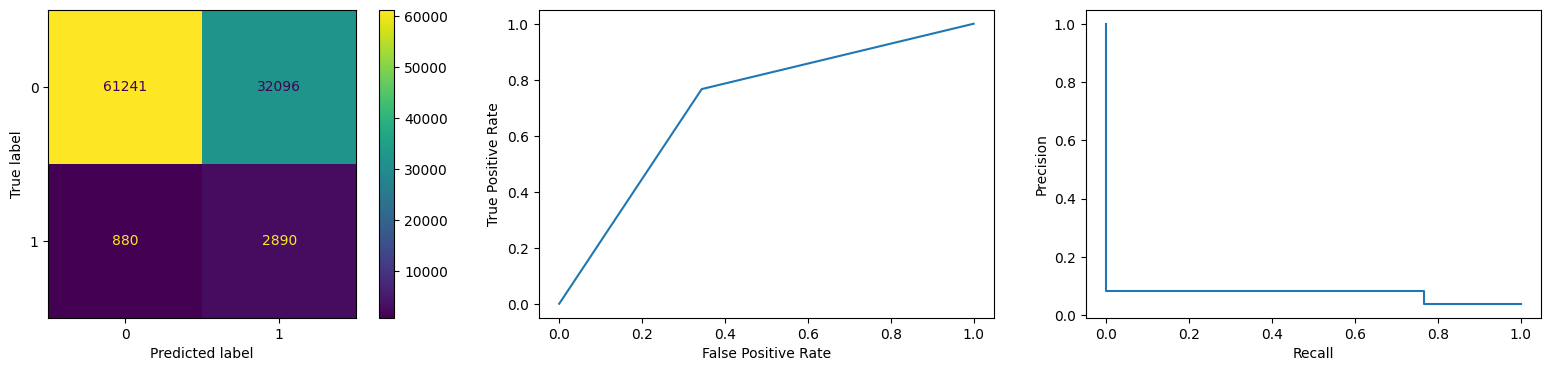

Result of select features
 - Accuracy: 0.6397993965419588
 - F1 Score: 0.1453772478498827


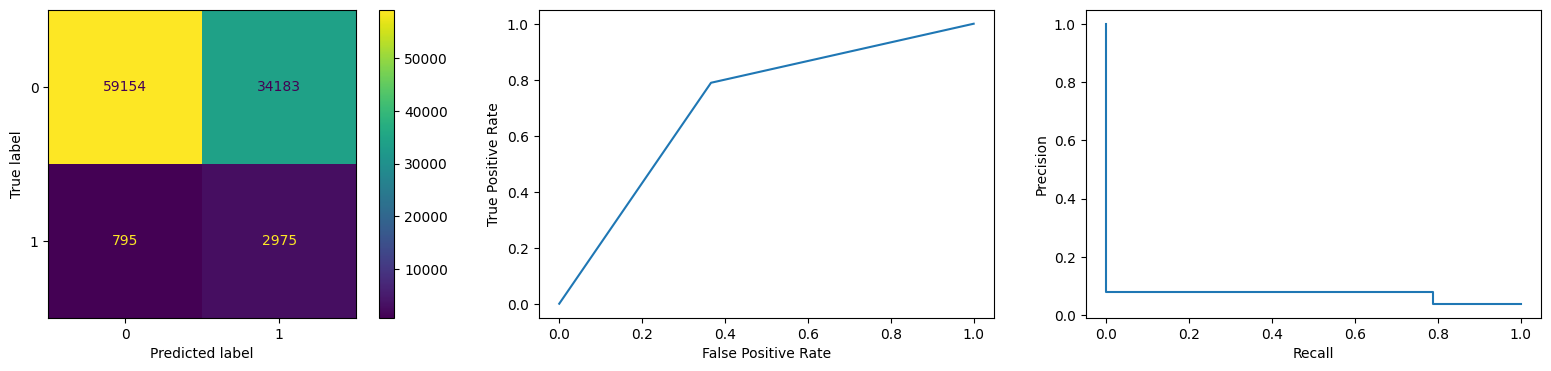

In [48]:
print('Result of all features')
print(' - Accuracy:', svc_all_opt.score(X_test, y_test))
print(' - F1 Score:', f1_score(y_test, svc_all_pred))

fig1, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 4))

cm_svc_all = confusion_matrix(y_test, svc_all_pred)
ConfusionMatrixDisplay(cm_svc_all).plot(ax=ax1)

fpr_svc_all, tpr_svc_all, _ = roc_curve(y_test, svc_all_pred)
roc_display_svc_all = RocCurveDisplay(fpr=fpr_svc_all, tpr=tpr_svc_all).plot(ax=ax2)

prec_svc_all, recall_svc_all, _ = precision_recall_curve(y_test, svc_all_pred)
pr_display_svc_all = PrecisionRecallDisplay(precision=prec_svc_all, recall=recall_svc_all).plot(ax=ax3)
plt.show()

print('Result of select features')
print(' - Accuracy:', svc_sel_opt.score(sel_X_test, y_test))
print(' - F1 Score:', f1_score(y_test, svc_sel_pred))

fig2, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 4))

cm_svc_sel = confusion_matrix(y_test, svc_sel_pred)
ConfusionMatrixDisplay(cm_svc_sel).plot(ax=ax1)

fpr_svc_sel, tpr_svc_sel, _ = roc_curve(y_test, svc_sel_pred)
roc_display_svc_sel = RocCurveDisplay(fpr=fpr_svc_sel, tpr=tpr_svc_sel).plot(ax=ax2)

prec_svc_sel, recall_svc_sel, _ = precision_recall_curve(y_test, svc_sel_pred)
pr_display_svc_sel = PrecisionRecallDisplay(precision=prec_svc_sel, recall=recall_svc_sel).plot(ax=ax3)
plt.show()

**SVC Conclusions**
- Naive model accuracy = 0.6625577970692124
- Accuracy and F1 score is slightly improved with all features
- Minimal difference in terms of accuarcy when compared to the naive model

### 7.2. Logistic Regression

In [49]:
lr_all_pred = lr_all_opt.predict(X_test)
lr_sel_pred = lr_sel_opt.predict(sel_X_test)

**Results**

Result of all features
 - Accuracy: 0.6887454045537397
 - F1 Score: 0.15324275108558622


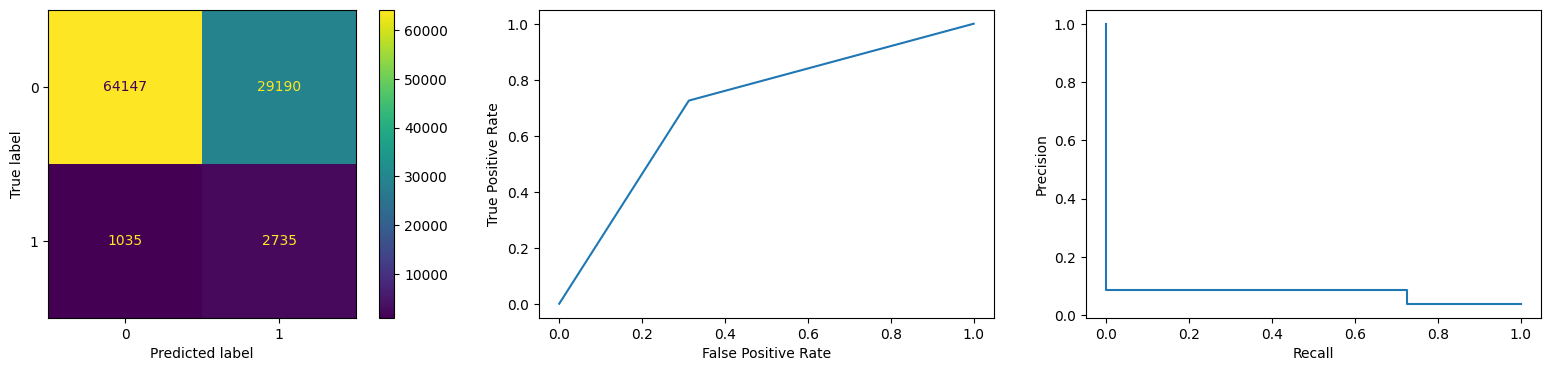

Result of select features
 - Accuracy: 0.6809498800292461
 - F1 Score: 0.14907992309805


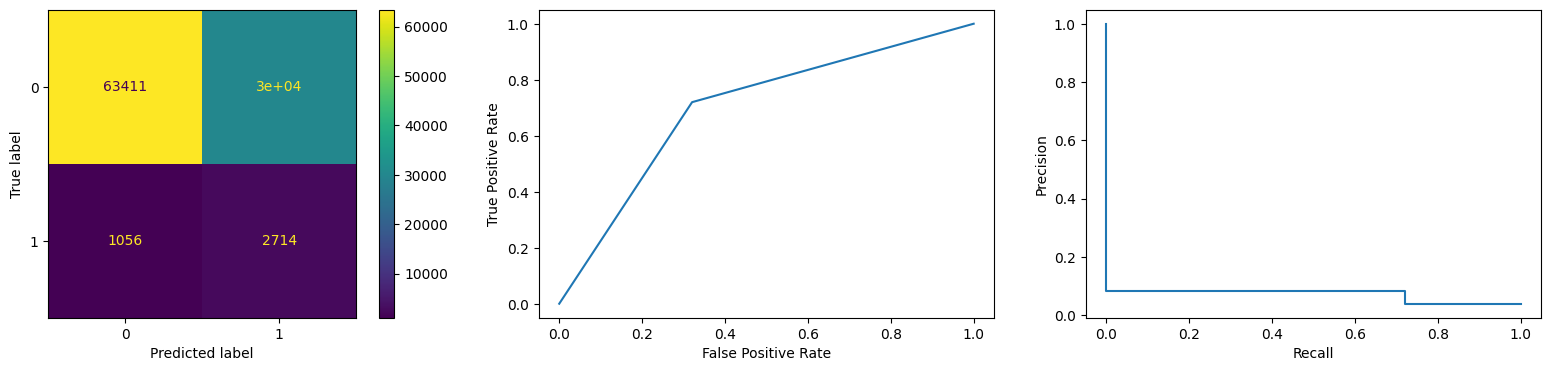

In [50]:
print('Result of all features')
print(' - Accuracy:', lr_all_opt.score(X_test, y_test))
print(' - F1 Score:', f1_score(y_test, lr_all_pred))

fig3, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 4))

cm_lr_all = confusion_matrix(y_test, lr_all_pred)
ConfusionMatrixDisplay(cm_lr_all).plot(ax=ax1)

fpr_lr_all, tpr_lr_all, _ = roc_curve(y_test, lr_all_pred)
roc_display_lr_all = RocCurveDisplay(fpr=fpr_lr_all, tpr=tpr_lr_all).plot(ax=ax2)

prec_lr_all, recall_lr_all, _ = precision_recall_curve(y_test, lr_all_pred)
pr_display_lr_all = PrecisionRecallDisplay(precision=prec_lr_all, recall=recall_lr_all).plot(ax=ax3)
plt.show()

print('Result of select features')
print(' - Accuracy:', lr_sel_opt.score(sel_X_test, y_test))
print(' - F1 Score:', f1_score(y_test, lr_sel_pred))

fig4, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 4))

cm_lr_sel = confusion_matrix(y_test, lr_sel_pred)
ConfusionMatrixDisplay(cm_lr_sel).plot(ax=ax1)

fpr_lr_sel, tpr_lr_sel, _ = roc_curve(y_test, lr_sel_pred)
roc_display_lr_sel = RocCurveDisplay(fpr=fpr_lr_sel, tpr=tpr_lr_sel).plot(ax=ax2)

prec_lr_sel, recall_lr_sel, _ = precision_recall_curve(y_test, lr_sel_pred)
pr_display_lr_sel = PrecisionRecallDisplay(precision=prec_lr_sel, recall=recall_lr_sel).plot(ax=ax3)
plt.show()

**Logistic Regression Conclusions**
- Naive model:
  - Accuracy = 0.6890852358738299
  - F1 score = 0.15333707234997196
- Using all features had slightly increased accuracy and F1 compared to select features
- Not a significant difference from the naive model

### 7.3. MLP

In [51]:
mlp_all_pred = mlp_all_opt.predict(X_test)
mlp_sel_pred = mlp_sel_opt.predict(sel_X_test)

**Results**

Result of all features
 - Accuracy: 0.6539899286354228
 - F1 Score: 0.1503995145140083


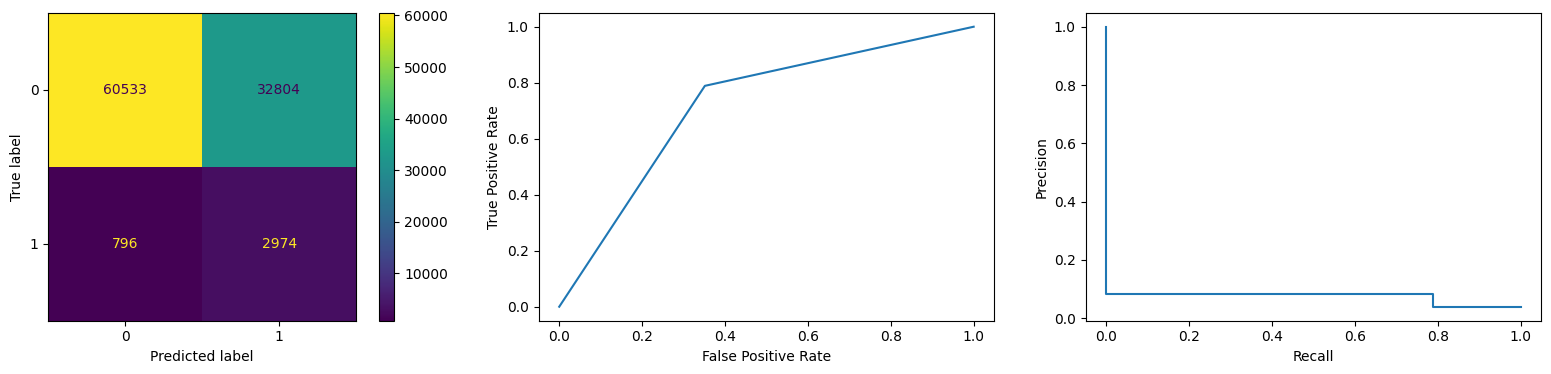

Result of select features
 - Accuracy: 0.6688292296126953
 - F1 Score: 0.15145518351407689


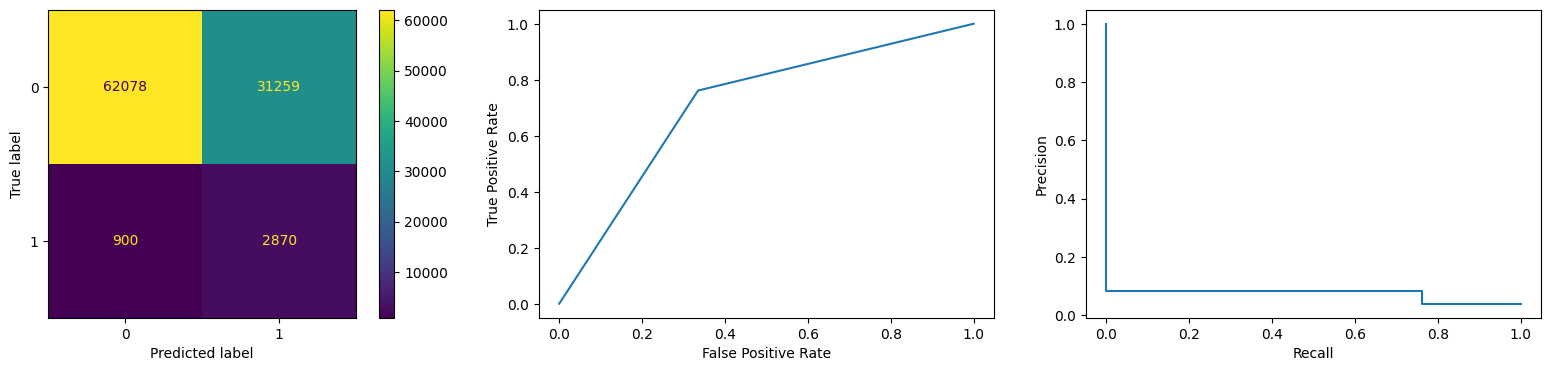

In [54]:
print('Result of all features')
print(' - Accuracy:', mlp_all_opt.score(X_test, y_test))
print(' - F1 Score:', f1_score(y_test, mlp_all_pred))

fig5, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 4))

cm_mlp_all = confusion_matrix(y_test, mlp_all_pred)
ConfusionMatrixDisplay(cm_mlp_all).plot(ax=ax1)

fpr_mlp_all, tpr_mlp_all, _ = roc_curve(y_test, mlp_all_pred)
roc_display_mlp_all = RocCurveDisplay(fpr=fpr_mlp_all, tpr=tpr_mlp_all).plot(ax=ax2)

prec_mlp_all, recall_mlp_all, _ = precision_recall_curve(y_test, mlp_all_pred)
pr_display_mlp_all = PrecisionRecallDisplay(precision=prec_mlp_all, recall=recall_mlp_all).plot(ax=ax3)
plt.show()

print('Result of select features')
print(' - Accuracy:', mlp_sel_opt.score(sel_X_test, y_test))
print(' - F1 Score:', f1_score(y_test, mlp_sel_pred))

fig6, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 4))

cm_mlp_sel = confusion_matrix(y_test, mlp_sel_pred)
ConfusionMatrixDisplay(cm_mlp_sel).plot(ax=ax1)

fpr_mlp_sel, tpr_mlp_sel, _ = roc_curve(y_test, mlp_sel_pred)
roc_display_mlp_sel = RocCurveDisplay(fpr=fpr_mlp_sel, tpr=tpr_mlp_sel).plot(ax=ax2)

prec_mlp_sel, recall_mlp_sel, _ = precision_recall_curve(y_test, mlp_sel_pred)
pr_display_mlp_sel = PrecisionRecallDisplay(precision=prec_mlp_sel, recall=recall_mlp_sel).plot(ax=ax3)
plt.show()

**MLP Conclusions**
- Naive model:
  - Accuracy = 0.6599524236151874
  - F1 score = 0.15115292665998303
- Using only select features had slightly increased accuracy and F1 compared to all features
- Not a significant difference from the naive model

### 7.4. AdaBoost

In [53]:
ab_all_pred = ab_all_opt.predict(X_test)
ab_sel_pred = ab_sel_opt.predict(sel_X_test)

**Results**

Result of all features
 - Accuracy: 0.699764177659695
 - F1 Score: 0.15661430761665077


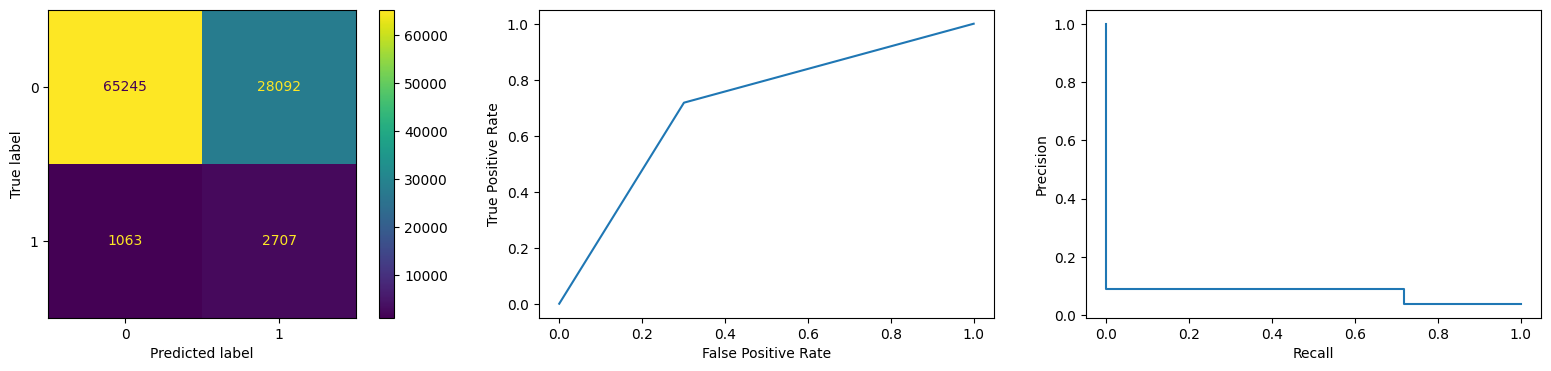

Result of select features
 - Accuracy: 0.688868979579227
 - F1 Score: 0.15433705600806114


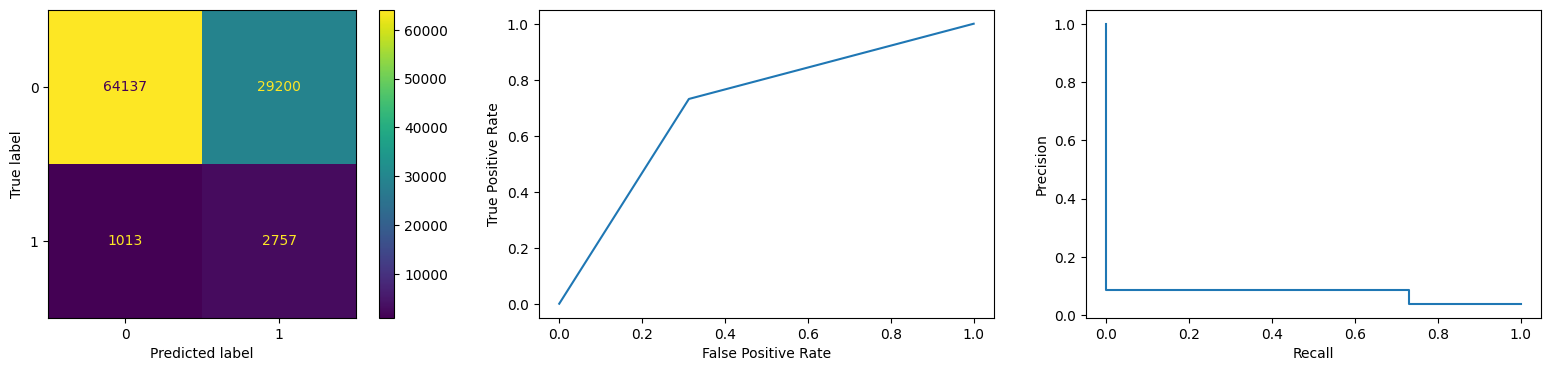

In [55]:
print('Result of all features')
print(' - Accuracy:', ab_all_opt.score(X_test, y_test))
print(' - F1 Score:', f1_score(y_test, ab_all_pred))

fig7, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 4))

cm_ab_all = confusion_matrix(y_test, ab_all_pred)
ConfusionMatrixDisplay(cm_ab_all).plot(ax=ax1)

fpr_ab_all, tpr_ab_all, _ = roc_curve(y_test, ab_all_pred)
roc_display_ab_all = RocCurveDisplay(fpr=fpr_ab_all, tpr=tpr_ab_all).plot(ax=ax2)

prec_ab_all, recall_ab_all, _ = precision_recall_curve(y_test, ab_all_pred)
pr_display_ab_all = PrecisionRecallDisplay(precision=prec_ab_all, recall=recall_ab_all).plot(ax=ax3)
plt.show()

print('Result of select features')
print(' - Accuracy:', ab_sel_opt.score(sel_X_test, y_test))
print(' - F1 Score:', f1_score(y_test, ab_sel_pred))

fig8, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 4))

cm_ab_sel = confusion_matrix(y_test, ab_sel_pred)
ConfusionMatrixDisplay(cm_ab_sel).plot(ax=ax1)

fpr_ab_sel, tpr_ab_sel, _ = roc_curve(y_test, ab_sel_pred)
roc_display_ab_sel = RocCurveDisplay(fpr=fpr_ab_sel, tpr=tpr_ab_sel).plot(ax=ax2)

prec_ab_sel, recall_ab_sel, _ = precision_recall_curve(y_test, ab_sel_pred)
pr_display_ab_sel = PrecisionRecallDisplay(precision=prec_ab_sel, recall=recall_ab_sel).plot(ax=ax3)
plt.show()

**AdaBoost Conclusions**
- Naive model:
  - Accuracy = 0.699764177659695
  - F1 score = 0.15661430761665077
- Using all features had slightly increased accuracy and F1 compared to select features
- No difference from the naive model

## 8. Conclusion  
**Accuracy**  
- Highest accuracy: AdaBoost (0.699764177659695), followed by Logistic Regression (0.6887454045537397)
- None of the model significantly outperformed the naive models

**F1 score**  
- Highest F1 score: AdaBoost (0.15661430761665077), followed by Logistic Regression (0.15324275108558622)
- Again, none of the model significantly outperformed the naive models

**Overall**  
1. Best model: AdaBoost (n_estimators=50, learning_rate=1) using all features.
2. All models had a high false positive rate which would need to be improved for this model to be used for stroke prediction.
3. All models had relatively low false negatives.
4. Considering the naive models performed similarly on the imbalanced dataset, it's possible the random under-sampling was unnecessary or removed useful information.
5. I think this dataset could be greatly improved with more data, especially in terms of the demographics of survey respondants.
6. I would like to explore including more features from the raw dataset that were not included in the literature as stroke risk factors. Including all of the features for pre-processing and then performing feature selection may have been a better method.


